Обычно мы работали с изображением постоянного размера. Но в некоторых случаях нам нужно работать с (одними и теми же) изображениями в разном разрешении. Например, при поиске чего-либо на изображении, например лица, мы не уверены, в каком размере объект будет присутствовать на этом изображении. В этом случае нам нужно будет создать набор одинаковых изображений с разным разрешением и искать объект во всех них. Эти наборы изображений с разным разрешением называются пирамидами изображений (потому что когда они хранятся в стопке с изображением с самым высоким разрешением внизу и изображением с самым низким разрешением вверху, это выглядит как пирамида).
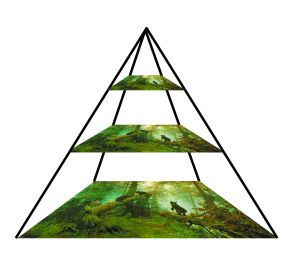


In [71]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [64]:
def show_orig_and_edit(orig, edit):
    plt.subplot(121), plt.imshow(orig, cmap='gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(edit, cmap='gray')
    plt.title('Edit'), plt.xticks([]), plt.yticks([])
    plt.show()

In [65]:
img = cv.imread(
    '../../image4labs/j.png')
assert img is not None, "file could not be read, check with os.path.exists()"

Существует два вида пирамид изображений.

1. Пирамида Гаусса
2. Пирамиды Лапласа.

Более высокий уровень (низкое разрешение) в гауссовой пирамиде формируется путем удаления последовательных строк и столбцов в изображении более низкого уровня (более высокое разрешение). Затем каждый пиксель на более высоком уровне формируется вкладом от 5 пикселей на базовом уровне с гауссовыми весами. Таким образом,М× Низображение становитсяМ/ 2×Н/ 2изображение. Таким образом, площадь уменьшается до одной четверти от исходной площади. Это называется Октавой. Та же картина продолжается по мере того, как мы поднимаемся выше в пирамиде (т.е. разрешение уменьшается). Аналогично при расширении площадь увеличивается в 4 раза на каждом уровне. Мы можем найти Гауссовы пирамиды, используя функции cv.pyrDown() и cv.pyrUp() .


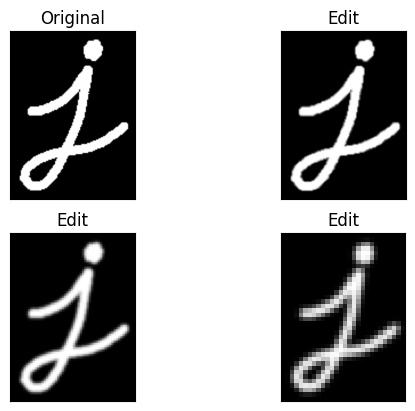

In [66]:
lower_reso1 = cv.pyrDown(img)
lower_reso2 = cv.pyrDown(lower_reso1)
lower_reso3 = cv.pyrDown(lower_reso2)

# plt.figure(figsize=(img.shape[0]//12, img.shape[1]//12))
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(lower_reso1, cmap='gray')
plt.title('Edit'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(lower_reso2, cmap='gray')
plt.title('Edit'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(lower_reso3, cmap='gray')
plt.title('Edit'), plt.xticks([]), plt.yticks([])
plt.show()

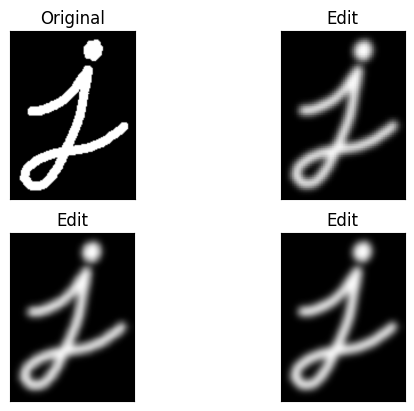

In [67]:
higher_reso1 = cv.pyrUp(lower_reso3)
higher_reso2 = cv.pyrUp(higher_reso1)
higher_reso3 = cv.pyrUp(higher_reso2)

# plt.figure(figsize=(img.shape[0]//12, img.shape[1]//12))
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(higher_reso1, cmap='gray')
plt.title('Edit'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(higher_reso2, cmap='gray')
plt.title('Edit'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(higher_reso3, cmap='gray')
plt.title('Edit'), plt.xticks([]), plt.yticks([])
plt.show()

Пирамида Лапласа основывается на методе Гаусса. На каждом своем уровне она хранит разность текущего уровня пирамиды Гаусса со следующим, тем самым сохраняя высокочастотный сигнал определенной частоты в узкой полосе. При комбинировании крайнего уменьшенного изображения со всеми уровнями пирамиды Лапласа получим исходное изображение (используется для сжатия изображений).

Блендинг изображений. Сначала строятся пирамиды Гаусса и Лапласа для каждого изображения. На каждом уровне пирамиды Лапласа происходит наложение изображений по маске (область, необходимая для вставки в исходную). На последнем этапе полученные изображения последовательно расширяются и сглаживаются. В силу того, что глубина пирамиды задается небольшой, происходит плавное наложение двух изображений.


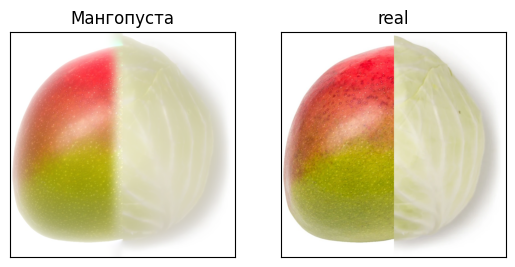

In [78]:
A = cv.imread(
    '../../image4labs/mango.webp')[..., ::-1]
B = cv.imread(
    '../../image4labs/kapusta.webp')[..., ::-1]
assert A is not None, "file could not be read, check with os.path.exists()"
assert B is not None, "file could not be read, check with os.path.exists()"
# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)
# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5, 0, -1):
    GE = cv.pyrUp(gpA[i])
    L = cv.subtract(gpA[i-1], GE)
    lpA.append(L)
# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5, 0, -1):
    GE = cv.pyrUp(gpB[i])
    L = cv.subtract(gpB[i-1], GE)
    lpB.append(L)
# Now add left and right halves of images in each level
LS = []
for la, lb in zip(lpA, lpB):
    rows, cols, dpt = la.shape
    ls = np.hstack((la[:, 0:cols//2], lb[:, cols//2:]))
    LS.append(ls)
# now reconstruct
ls_ = LS[0]
for i in range(1, 6):
    ls_ = cv.pyrUp(ls_)
    ls_ = cv.add(ls_, LS[i])
# image with direct connecting each half
real = np.hstack((A[:, :cols//2], B[:, cols//2:]))
plt.subplot(121), plt.imshow(ls_, cmap='gray')
plt.title('Мангопуста'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(real, cmap='gray')
plt.title('real'), plt.xticks([]), plt.yticks([])
plt.show()